In [1]:
from MinerlNavigate_utils import *
from MinerlNavigate_models import Actor, Critic
import keras.backend as K
import tensorflow as tf
import gym 
import minerl
import matplotlib.pyplot as plt
from time import time

Using TensorFlow backend.


In [2]:
buffer_size = 100000
batch_size = 128
gamma = 0.99
tau = 0.001
lr_actor = 0.0001
lr_critic = 0.001
    
action_size = 9
state_size = (64, 64, 3)
    
rate = 0.2
epsilon = 0.01
render = True

In [3]:
def train_from_memory(mission, buff, actor, critic, batch_size = 128, sequence = False):
    
    gamma = 0.99
    
    batch = buff.getBatch(batch_size, sequence)
    #batch_size -= 1
    states = np.asarray([e[0] for e in batch])
    states_pov = np.stack([s['pov'][0] for s in states])
    states_cA = np.stack([s['compassAngle'][0] for s in states])
    actions = np.asarray([e[1] for e in batch])
    #actions = np.stack([a[0] for a in actions])
    
    rewards = np.asarray([e[2] for e in batch])

    next_states = np.asarray([e[3] for e in batch])
    next_states_pov = np.stack([ns['pov'][0] for ns in next_states])
    next_states_cA = np.stack([ns['compassAngle'][0] for ns in next_states])

    dones = np.asarray([e[4] for e in batch])
    
    target_actions = actor.target_predict([next_states_pov, next_states_cA])
    target_q_values = critic.target_predict([next_states_pov, next_states_cA, target_actions])
     
    critic_target = np.asarray(target_q_values)
    for i in range(target_q_values.shape[0]):
        if dones[i]:
            critic_target[i] = rewards[i]
        else:
            critic_target[i] = rewards[i] + gamma * target_q_values[i]

    critic.train_on_batch(states_pov, states_cA, actions, critic_target) 
   
    action_for_grads = actor.predict([states_pov, states_cA])
    grads = critic.gradients(states_pov, states_cA, action_for_grads)
    actor.train(states_pov, states_cA, np.array(grads).reshape(-1, 9))
    actor.transfer_weights()
    critic.transfer_weights()
    
    return buff, actor, critic


def train_on_batch(state, action, reward, next_state, done, actor, critic):
    
    q_values = critic.target_predict([next_state['pov'], next_state['compassAngle'], action])
    
    critic_target = np.asarray(q_values)
    for i in range(q_values.shape[0]):
        if done[i]:
            critic_target[i] = reward[i]
        else:
            critic_target[i] = reward[i] + gamma * q_values[i]
    
    critic.train_on_batch(state['pov'], state['compassAngle'], action, critic_target)
        
    actions = actor.predict([state['pov'], state['compassAngle']])
    #print(actions)
    gradients = critic.gradients(state['pov'], state['compassAngle'], actions)
    actor.pre_train(state['pov'], state['compassAngle'], action)
    
    actor.transfer_weights()
    critic.transfer_weights()
    #print('Done!')
    
def pretrain2(mission, buff, actor, critic, batch_size = 128):
    max_iterations = 1
    outerstepsize0 = 0.1
    
    data = minerl.data.make(mission)
        
    for iteration in range(1, max_iterations+1):
        print('--------------------------------------------------------------')
        t1 = time()
        print('Starting outer loop...iteration ',iteration, '/',max_iterations)
        old_weights = actor.model.get_weights()
        #print(old_weights)
        print('Starting inner loop....')
        for state, action, reward, next_state, done in data.sarsd_iter(num_epochs=1, max_sequence_len=batch_size, sample_no = sample_no):
            batch_size = state['pov'].shape[0]
            if(state['pov'].shape != (batch_size,64,64,3)):
                print('skipping batch....found unexpected array size', state['pov'].shape)
            else:
                state = observation_wrapper(state, batch_size)
                action = map_from_actionset(action, batch_size)
                #print(action.shape)
                #print('Batch ready!!...Beginning training....')        
                train_on_batch(state, action, reward, next_state, done, actor, critic)
        print('Done!')
        new_weights = actor.model.get_weights()

        outerstepsize = outerstepsize0 * (1 - iteration/max_iterations)
        print('Updating weights...')        
        modified_weights = []
        for i in range(len(old_weights)):
            value = old_weights[i] + (new_weights[i] - old_weights[i])*outerstepsize
            modified_weights.append(value)  
        print('Setting new weights to model...')            
        actor.model.set_weights(modified_weights)
        print('End of OuterLoop....')
        print('Time taken:', (time()-t1)/3600, 'hrs')
        actor.save('navigatedense')
        critic.save('navigatedense')
    return buff, actor, critic

In [4]:
actor = Actor(state_size, action_size, lr_actor, tau)
critic = Critic(state_size, action_size, lr_critic, tau)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
buff = ReplayBuffer(buffer_size)

In [6]:
mission = 'MineRLNavigateDense-v0'

In [ ]:
buff, actor, critic = pretrain2(mission, buff, actor, critic, batch_size)

        

In [7]:
 env = gym.make(mission)

In [8]:
try:
    actor.load_weights("navigatedense_actor.h5")
    critic.load_weights("navigatedense_critic.h5")
    actor.load_targetweights("navigatedense_actortarget.h5")
    critic.load_targetweights("navigatedense_critictarget.h5")
    print("Successfully loaded previously trained weights!")
except:
    print("Saved model not found...starting training from scratch")
        

Successfully loaded previously trained weights!


# Training

Episode : 0 Replay Buffer 0
episode: 0/1, mean reward: -0.00026065572102864585, e: 0.01
Time taken: 7.419208641846975 mins
Training completed!!!


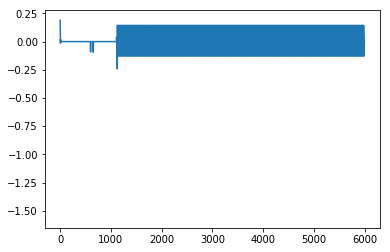

In [9]:
train = False
track_reward = []
max_episodes = 1
render = True
frames = 1  # DO NOT CHANGE
batch_size = 32

for episode in range(max_episodes):
    t1 = time()
    print("Episode : " + str(episode) + " Replay Buffer " + str(buff.count()))
        
    state = env.reset()
    state = observation_wrapper(state, frames)
    done = False
    episode_reward = []
        
    while not done:
        if render:
            env.render()
        
        action_vec = actor.predict([state['pov'],state['compassAngle']])
        #print(action_vec)    
        if train:
            action_vec = add_noise(action_vec[0], epsilon)
            #print(action_vec)
            epsilon = epsilon*((1+rate)**episode)  
        action = map_to_actionset(mission, action_vec[0])
        #print(action)    
        next_state, reward, done, _ = env.step(action)
        next_state = observation_wrapper(next_state, frames)
        #done_ = 0 if done else 1
        episode_reward.append(reward)
        
        if train:
            buff.add(state, action_vec, reward, next_state, done)
            if buff.count() > batch_size:
                train_from_memory(mission, buff, actor, critic, batch_size)

        state = next_state
            
            
        if done:
            track_reward.append(np.sum(episode_reward))
            print("episode: {}/{}, mean reward: {}, e: {:.2}"
                .format(episode, max_episodes, np.mean(episode_reward), epsilon))
            plt.plot(range(len(episode_reward)), episode_reward)    
                
            break
    print('Time taken:', (time()-t1)/60, 'mins')
    if train:    
        if episode % 5 == 0:
            actor.model.save_weights('train_navigatedense_actor.h5', overwrite=True)
            actor.target_model.save_weights('train_navigatedense_actortarget.h5', overwrite=True)
            critic.model.save_weights('train_navigatedense_critic.h5', overwrite=True)
            critic.target_model.save_weights('train_navigatedense_critictarget.h5', overwrite=True)

print('Training completed!!!')
plt.plot(range(max_episodes), track_reward)

In [12]:
env.close()

Failed to delete the temporary minecraft directory.
